In [1]:
import numpy as np
from pydmd import DMD
import tensorflow as tf

In [2]:
# Import data from data/PSEI.csv to numpy array
# Get only the closing price (usecols=4)
data = np.genfromtxt('data/PSEI.csv', delimiter=',', skip_header=1, usecols=4)
print(f"Length of data: {len(data)}")
print(f"Closing Prices: {data}")

Length of data: 5675
Closing Prices: [2141.77 2153.18 2074.75 ... 6923.08 6842.79 6876.79]


In [3]:
# Split data into training and testing
len_train = int(len(data) * 0.80)
data_train = data[:len_train]
print(f"Length of data_train: {len(data_train)}\nData Train: {data_train}\n")
data_test = data[len_train:]
print(f"Length of data_test: {len(data_test)}\nData Test: {data_test}")

Length of data_train: 4540
Data Train: [2141.77 2153.18 2074.75 ... 7267.34 7348.42 7233.57]

Length of data_test: 1135
Data Test: [7186.71 7186.62 7233.29 ... 6923.08 6842.79 6876.79]


In [4]:
# Create a windowed dataset from the training data (window_size=10)
window_size = 5

train_data = np.zeros((len(data_train) - window_size, window_size))
for i in range(len(data_train) - window_size):
    train_data[i] = data_train[i:i + window_size]
print(f"Shape of train_data: {train_data.shape}\nTrain Data: {train_data}")

Shape of train_data: (4535, 5)
Train Data: [[2141.77 2153.18 2074.75 2079.11 2094.29]
 [2153.18 2074.75 2079.11 2094.29 2142.25]
 [2074.75 2079.11 2094.29 2142.25 2140.78]
 ...
 [7007.21 7176.43 7066.57 7193.68 7227.96]
 [7176.43 7066.57 7193.68 7227.96 7267.34]
 [7066.57 7193.68 7227.96 7267.34 7348.42]]


In [5]:
# Find the dynamic modes of the training data
dmd = DMD(svd_rank=1, tlsq_rank=1, exact=True)
dmd.fit(train_data.T)
mode = dmd.modes
print(f"Shape of mode: {mode.shape}\nMode: {mode}")

Shape of mode: (5, 1)
Mode: [[-0.44710127]
 [-0.44722249]
 [-0.44733435]
 [-0.44743621]
 [-0.4475299 ]]


In [6]:
# Set up the model (integrate the dynamic mode)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(1, input_shape=(window_size,)))
model.layers[0].set_weights([abs(mode), np.zeros(1)])
model.layers[0].trainable = True

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(train_data, data_train[window_size:], epochs=100, verbose=0)

In [7]:
# Predict the next 10 values
pred = model.predict(train_data)
print(f"Shape of pred: {pred.shape}\nPred: {pred}")

142/142 [==============================] - 0s 884us/step
Shape of pred: (4535, 1)
Pred: [[2091.738 ]
 [2107.1436]
 [2113.914 ]
 ...
 [7144.1553]
 [7191.9688]
 [7242.0293]]


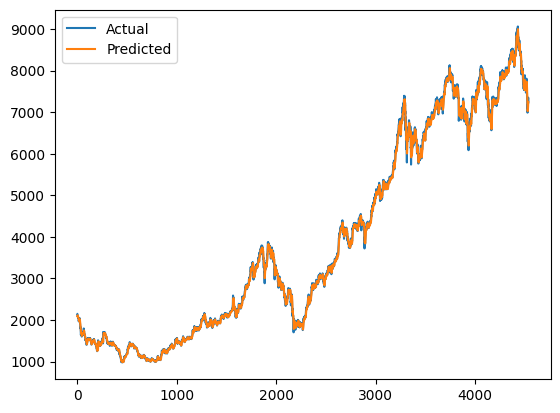

In [8]:
# Plot actual vs predicted
import matplotlib.pyplot as plt

plt.plot(data_train[window_size:], label='Actual')
plt.plot(pred, label='Predicted')
plt.legend()
plt.show()

Shape of test_data: (1130, 5)
Test Data: [[7186.71 7186.62 7233.29 7333.73 7350.58]
 [7186.62 7233.29 7333.73 7350.58 7399.18]
 [7233.29 7333.73 7350.58 7399.18 7369.44]
 ...
 [7035.76 6986.19 7027.38 6936.61 6881.26]
 [6986.19 7027.38 6936.61 6881.26 6923.08]
 [7027.38 6936.61 6881.26 6923.08 6842.79]]
36/36 [==============================] - 0s 944us/step
Shape of pred: (1130, 1)
Pred: [[7270.723 ]
 [7314.7383]
 [7333.4277]
 ...
 [6922.3477]
 [6910.1963]
 [6874.677 ]]


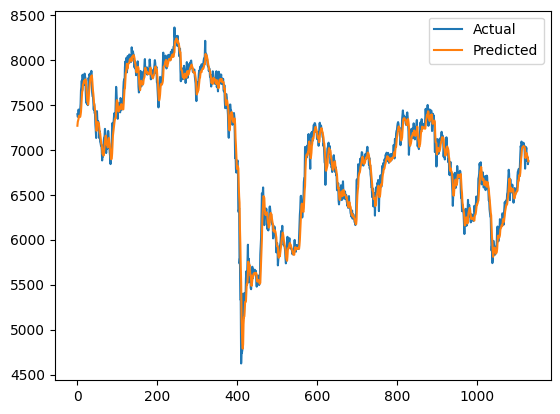

In [9]:
# Predict using the test data
test_data = np.zeros((len(data_test) - window_size, window_size))
for i in range(len(data_test) - window_size):
    test_data[i] = data_test[i:i + window_size]
print(f"Shape of test_data: {test_data.shape}\nTest Data: {test_data}")

pred = model.predict(test_data)
print(f"Shape of pred: {pred.shape}\nPred: {pred}")

# Plot actual vs predicted
plt.plot(data_test[window_size:], label='Actual')
plt.plot(pred, label='Predicted')
plt.legend()
plt.show()

In [11]:
# Test input
test_input = np.array([2.9573, 2.9957, 3.3029, 3.2645, 3.2261])

# Predict the next value
pred = model.predict(test_input.reshape(1, -1))
print(f"Shape of pred: {pred.shape}\nPred: {pred}")

1/1 [==============================] - 0s 22ms/step
Shape of pred: (1, 1)
Pred: [[3.23936]]
